<a href="https://colab.research.google.com/github/nikagrawal90/Stock_Market_Value_Prediction/blob/main/Stock_Market_Value_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_original = pd.read_csv('/AAPL.csv')
df_original

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.0500,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.1000,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.9000,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.0500,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.3200,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.960,316.500,310.3241,313.17,33843125,314.960000,316.500000,310.324100,313.170000,33843125,0.0,1.0
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.140,318.520,313.0100,315.03,25432385,313.140000,318.520000,313.010000,315.030000,25432385,0.0,1.0
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.230,319.520,316.2000,316.68,27876215,319.230000,319.520000,316.200000,316.680000,27876215,0.0,1.0
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.850,320.890,315.8700,318.66,25672211,316.850000,320.890000,315.870000,318.660000,25672211,0.0,1.0


In [ ]:
df_original.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [ ]:
df_original.tail()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.96,316.50,310.3241,313.17,33843125,314.96,316.50,310.3241,313.17,33843125,0.0,1.0
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.14,318.52,313.0100,315.03,25432385,313.14,318.52,313.0100,315.03,25432385,0.0,1.0
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.23,319.52,316.2000,316.68,27876215,319.23,319.52,316.2000,316.68,27876215,0.0,1.0
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.85,320.89,315.8700,318.66,25672211,316.85,320.89,315.8700,318.66,25672211,0.0,1.0
1257,1257,AAPL,2020-05-22 00:00:00+00:00,318.89,319.23,315.3500,315.77,20450754,318.89,319.23,315.3500,315.77,20450754,0.0,1.0


In [ ]:
df_original = df_original['close']

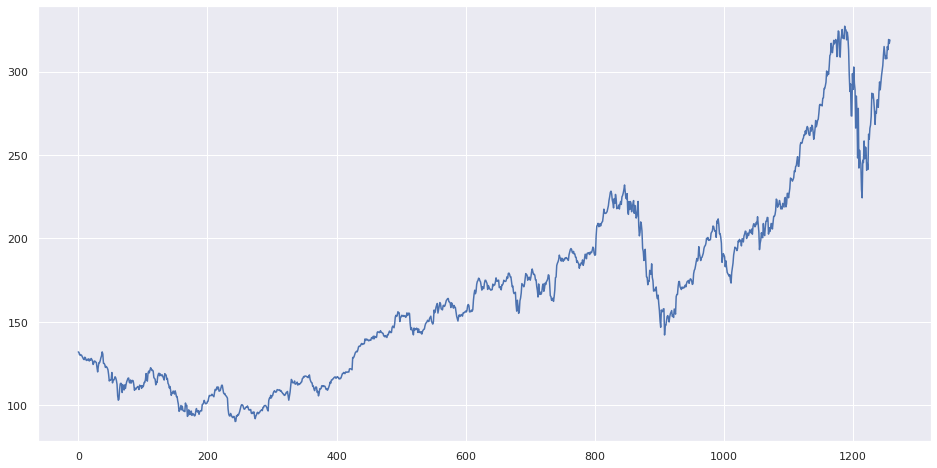

In [ ]:
sns.set_theme()
plt.figure(figsize=(16,8))
plt.plot(df_original)
plt.show();

#Preprocess Data
####LSTM is sensitive for scaling thus apply MinMaxScaler.

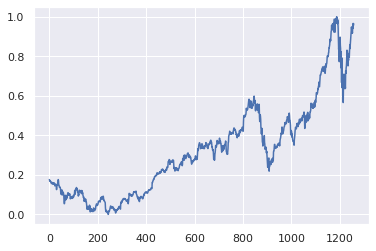

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(np.array(df_original).reshape(-1,1))
plt.plot(df_scaled)

In [84]:
training_size = int((len(df_scaled)*0.7))

training_data = df_scaled[:training_size]
test_data = df_scaled[training_size:]
training_data[0,0]

0.1760744743730473

In [85]:
def make_dataset(dataset, time_step=1):
  X, y = [], []
  for i in range(len(dataset)-time_step):
    X.append(dataset[i:i+time_step,0])
    y.append(dataset[i+time_step,0])
  return np.array(X), np.array(y)

In [90]:
time_step=100
X_train, y_train = make_dataset(training_data,time_step)
X_test, y_test = make_dataset(test_data,time_step)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(717, 100) (717,)
(341, 100) (341,)


In [91]:
# Reshape the dimensions as expected by LSTM [no of samples, time step, no of features]
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

Stacked LSTM Model

In [92]:
#importing useful libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [93]:
#Creating model
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [95]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [122]:
# Train model
h = model.fit(X_train, y_train, batch_size=64, epochs=10)

Epoch 1/10
12/12 [==============================] - 2s 168ms/step - loss: 4.9862e-04
Epoch 2/10
12/12 [==============================] - 2s 167ms/step - loss: 4.6823e-04
Epoch 3/10
12/12 [==============================] - 2s 167ms/step - loss: 5.0664e-04
Epoch 4/10
12/12 [==============================] - 2s 173ms/step - loss: 4.8718e-04
Epoch 5/10
12/12 [==============================] - 2s 172ms/step - loss: 4.6863e-04
Epoch 6/10
12/12 [==============================] - 2s 172ms/step - loss: 4.4466e-04
Epoch 7/10
12/12 [==============================] - 2s 165ms/step - loss: 4.2183e-04
Epoch 8/10
12/12 [==============================] - 2s 163ms/step - loss: 4.2291e-04
Epoch 9/10
12/12 [==============================] - 2s 165ms/step - loss: 4.2385e-04
Epoch 10/10
12/12 [==============================] - 2s 163ms/step - loss: 4.1543e-04


In [113]:
#Calculate predictions on train and test set
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

In [114]:
#Remove scaling according to feature range
train_prediction = scaler.inverse_transform(train_prediction)
test_prediction = scaler.inverse_transform(test_prediction)

In [115]:
import math
from sklearn.metrics import mean_squared_error

In [119]:
rmse_train = math.sqrt(mean_squared_error(y_train, train_prediction))

In [120]:
rmse_test = math.sqrt(mean_squared_error(y_test, test_prediction))

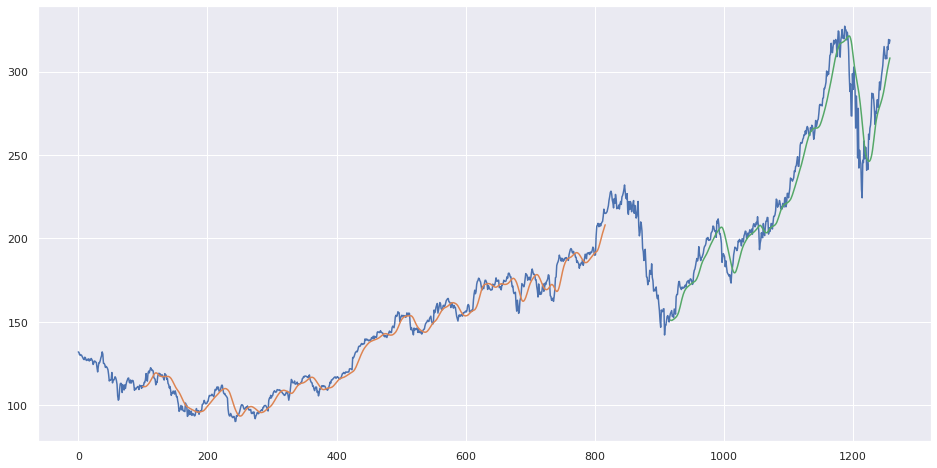

In [118]:
# shifting training prediction for plotting
train_predict_plot = np.empty_like(df_scaled)
train_predict_plot[:,:] = np.nan
train_predict_plot[time_step : time_step + len(train_prediction),:] = train_prediction

test_predict_plot = np.empty_like(df_scaled)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_prediction)+time_step*2:,:] = test_prediction

#plotting
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(df_scaled))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show();

In [ ]:
# We can see here that our model can fit well on training set as well as test set

In [124]:
print("RMSE train :", rmse_train)
print("RMSE test :", rmse_test)
print("Loss :", h.history['loss'])
print("Model Accuracy :", 100-h.history['loss'][0])

RMSE train : 140.9442253225614
RMSE test : 235.1428740025195
Loss : [0.0004986185231246054, 0.0004682301077991724, 0.0005066438461653888, 0.0004871782730333507, 0.00046863401075825095, 0.00044465941027738154, 0.00042183499317616224, 0.00042290505371056497, 0.0004238472902216017, 0.0004154300841037184]
Model Accuracy : 99.99950138147688
